In [1]:
import os, re
import pandas as pd
from bs4 import BeautifulSoup

import librosa.display
import matplotlib.pyplot as plt
from pprint import pprint
from IPython.display import Audio, display

import torch
import whisperx

In [2]:
# Hardcoded Values
SAMPLING_RATE = 16000 # All models predict on a monochannel 16khz tensor

In [3]:
device = "cuda" if torch.cuda.is_available() else 'cpu'
example_5_min = "../data/db short intro.ogg"
model_file = '../models/whisper/small.en.pt'
audacity_dir = '../data/db_02-03-2023/'
silero_dir = '../models/silero-vad'

In [4]:
def vizualize_waveform(waveform, rate=SAMPLING_RATE):
    plt.figure(figsize=[7,2.5])
    librosa.display.waveshow(waveform, sr=rate)
    plt.show()

def listen_waveform(waveform, rate=SAMPLING_RATE):
    display(Audio(waveform, rate=rate))

## Loading audio using whisperx

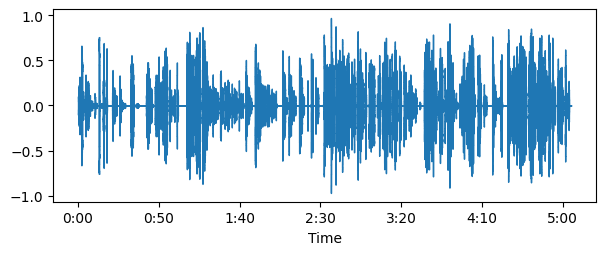

In [11]:
waveform = whisperx.load_audio(example_5_min)
vizualize_waveform(waveform)

In [5]:
whisper_model = whisperx.load_model(model_file, device)


silero_vad, utils =    torch.hub.load(repo_or_dir=silero_dir,
                               source='local',
                               model='silero_vad',
                               force_reload=True,
                               onnx=False)

(get_speech_timestamps,
 save_audio,
 read_audio,
 VADIterator,
 collect_chunks) = utils


In [6]:
align_model, metadata = whisperx.load_align_model(language_code='en', device=device)

## Loading an Audacity project

In [7]:
# print(audacity_dir)

def find_aup_file(path):
    aup_files = [f for f in os.listdir(path) if f.endswith('.aup')]
    return aup_files[0] # Assume only one file per directory

def parse_audacity_project(path_to_aup_file):
    
    with open(path_to_aup_file, 'r') as f:
        aup = BeautifulSoup(f, features="lxml-xml")
    
    root_path = os.path.split(path_to_aup_file)[:-1]
    root_path = os.path.join(*root_path)

    project = aup.find('project')
    proj_name = project.get('projname')
    data_path = os.path.join(root_path, proj_name)

    proj_imports = project.find_all('import')
    proj_files = []
    for item in proj_imports:
        filename, offset= item.get('filename'), float(item.get('offset'))
        entry = {
            'filename': filename,
            'offset': offset
        }
        proj_files.append(entry)

    
    output = {
        'project_name' : proj_name,
        'root_path': root_path,
        'data_path': data_path,
        'files': proj_files
    }

    return output

In [8]:
path = os.path.join(audacity_dir, find_aup_file(audacity_dir))

project = parse_audacity_project(path)
pprint(project)

{'data_path': '../data/db_02-03-2023\\V8DcTChKFF_data',
 'files': [{'filename': '1-CS12_4510.ogg', 'offset': 0.0},
           {'filename': '2-Crux_4429.ogg', 'offset': 0.0},
           {'filename': '3-JadePixie_7138.ogg', 'offset': 0.0},
           {'filename': '4-IlMaximuslI_9218.ogg', 'offset': 0.0}],
 'project_name': 'V8DcTChKFF_data',
 'root_path': '../data/db_02-03-2023'}


I am using a discord bot called craig to collect my data.  It saves files with discord names included which I intend to extract.

In [9]:
def get_discord_name(filename):
    discord_name_pattern = r'.+-(.*)\..+'
    username = re.search(discord_name_pattern, filename).group(1)
    return username

## Processing a file

In [11]:
vad_segments = get_speech_timestamps(waveform, silero_vad)

c:\Python\3.10.8\lib\site-packages\torch\nn\modules\module.py:1194: UserWarning: operator () profile_node %668 : int[] = prim::profile_ivalue(%666)
 does not have profile information (Triggered internally at ..\torch\csrc\jit\codegen\cuda\graph_fuser.cpp:109.)
  return forward_call(*input, **kwargs)


In [12]:
speech_only_waveform = collect_chunks(vad_segments, torch.tensor(waveform))

In [13]:
speech_only_segments = []
current_frame = 0
for i, entry in enumerate(vad_segments):
    speech_length = entry['end'] - entry['start']
    end_frame = current_frame + speech_length
    speech_only_segments.append(
        {'start': current_frame,
         'end': end_frame
        }
        )
    current_frame = end_frame

In [14]:
# Make sure the resulting segments aligns with the audio data
assert speech_only_segments[-1]['end'] == speech_only_waveform.shape[0] and speech_only_segments[0]['start'] == 0

In [15]:
df = []
for i, (orig, short) in enumerate(zip(vad_segments, speech_only_segments)):
    df.append({
        'id': i,
        'start': orig['start'],
        'end': orig['end'],
        'short_start': short['start'],
        'short_end': short['end']
    })

df = pd.DataFrame(df)
df.head()

,id,start,end,short_start,short_end
0,0,4640,23008,0,18368
1,1,30240,56288,18368,44416
2,2,81440,90592,44416,53568
3,3,95776,107488,53568,65280
4,4,121888,150496,65280,93888


Now I have shortened waveform to feed to whisper and a map that will allow me to translate timestamps back to their original position.

In [16]:
results = whisper_model.transcribe(speech_only_waveform)

In [17]:
results['text']

" Oh my god, he's loud again. Hello Craig. Turn him down. He was down. Now he's loud again. Well that's because you broke your ears. Hello. Hello. Hello my friend. Hi. Welcome. We got a session of D&D coming up. Last time, it's kinda interesting. We all somehow lived. We have. Yeah. It is a pretty, pretty amazing thing. We got very lucky, apparently. And I guess unintentionally very well prepared. very well prepared you're right. We bought our potions, we got our supplies, we had Miley and called the ritual and then we went to a place where everything was bad. I'm not bad at it, but most of it is. We got to watch a dreamlike sequence where the inhabitants of Adam's past did like this dark ritual thing, it involved human sacrifice and then you know opened a portal to the far realm and stuff. And it basically just kind of fucked up reality in this place. But also it kind of felt like a lot of the fucked up-ness was because there was an inevitable there who was destroying and recreating t

In [18]:
result_aligned = whisperx.align(results["segments"], align_model, metadata, speech_only_waveform, device)

In [19]:
adf = pd.DataFrame(result_aligned['word_segments'])
adf[['start','end']] = (adf[['start','end']] * SAMPLING_RATE).astype(int)
adf

,text,start,end
0,Oh,0,1302
1,my,1628,2604
2,"god,",2930,5535
3,he's,6512,9117
4,loud,9768,13024
...,...,...,...
530,at,3083481,3084765
531,times.,3085728,3092471
532,Very,3100858,3104413
533,"contrary,",3105060,3113464


In [20]:
def get_segment_overlap_percent(segment, word):
    olap = range(max(segment[0], word[0]), min(segment[-1], word[-1])+1)
    return len(olap) / len(word)

segment_ranges = [range(x,y) for x,y in df[['short_start','short_end']].values]
word_ranges = [range(x,y) for x,y in adf[['start','end']].values]

l = []
for word_segment in word_ranges:
    for i, segment in enumerate(segment_ranges):
        if get_segment_overlap_percent(segment, word_segment) > .5:
            l.append(i)
            break
adf['parent_id'] = l

In [21]:
# f = lambda x: adf[(adf.start >= x['short_start']) & (adf.start < x['short_end'])]
# df['word_segments'] = df.apply(f, axis=1)
# df.head()

In [22]:
f = lambda x: adf[adf['parent_id'] == x['id']]
df['word_segments'] = df.apply(f, axis=1)
df.head()

,id,start,end,short_start,short_end,word_segments
0,0,4640,23008,0,18368,text start end parent_id 0 Oh ...
1,1,30240,56288,18368,44416,text start end parent_id 6 Hello...
2,2,81440,90592,44416,53568,text start end parent_id 11 He 5186...
3,3,95776,107488,53568,65280,text start end parent_id 12 was ...
4,4,121888,150496,65280,93888,text start end parent_id 14 N...


In [23]:
f = lambda x: ' '.join(x['word_segments']['text'].to_list())
df['text'] = df.apply(f, axis=1)
df.head()

,id,start,end,short_start,short_end,word_segments,text
0,0,4640,23008,0,18368,text start end parent_id 0 Oh ...,"Oh my god, he's loud again."
1,1,30240,56288,18368,44416,text start end parent_id 6 Hello...,Hello Craig. Turn him down.
2,2,81440,90592,44416,53568,text start end parent_id 11 He 5186...,He
3,3,95776,107488,53568,65280,text start end parent_id 12 was ...,was down.
4,4,121888,150496,65280,93888,text start end parent_id 14 N...,Now he's loud again. Well that's because you b...


In [24]:
df.shape

(107, 7)

In [25]:
# for idx, row in df.iterrows():
#     # if idx in range(3,6):
#         print(row[['text','short_start','short_end']])
#         display(row['word_segments'])
#         listen_waveform(speech_only_waveform[row['short_start']:row['short_end']])

There are still some problems with words not aligning perfectly with when they were actually spoken.  This is likely due to overlapping speech and errors in the source transcription.  I expect this will be aleviated when processing multi-track data with one speaker per track.

However, the overall performance is still *very* good.  Let's package everything done so far into a function.

In [62]:
def get_segment_overlap_percent(parent: range, child: range) -> float:
    """Calculates the percentage of which the child's boundries fit within the parent's boundries."""
    olap = range(max(parent[0], child[0]), min(parent[-1], child[-1])+1)
    olap_percent = len(olap) / len(child)
    return olap_percent

def get_vad_data(audio):
    """Process Silero VAD on audio waveform.
    Returns:
    df, speech_only_waveform, (vad_segments, speech_only_segments)"""
    vad_segments = get_speech_timestamps(audio, silero_vad)
    speech_only_waveform = collect_chunks(vad_segments, torch.tensor(audio))
    
    speech_only_segments = []
    current_frame = 0
    for i, entry in enumerate(vad_segments):
        speech_length = entry['end'] - entry['start']
        end_frame = current_frame + speech_length
        speech_only_segments.append(
            {'start': current_frame,
            'end': end_frame
            }
            )
        current_frame = end_frame

    df = []
    for i, (orig, short) in enumerate(zip(vad_segments, speech_only_segments)):
        df.append({
            'id': i,
            'start': orig['start'],
            'end': orig['end'],
            'so_start': short['start'],
            'so_end': short['end']
        })

    df = pd.DataFrame(df)

    return df, speech_only_waveform, (vad_segments, speech_only_segments)

def transcribe_and_align(audio):
    results = whisper_model.transcribe(audio)
    results_aligned = whisperx.align(results["segments"], align_model, metadata, audio, device)
    df = pd.DataFrame(results_aligned['word_segments'])
    df[['start','end']] = (df[['start','end']] * SAMPLING_RATE).astype(int)

    return df, results_aligned

def process_audio(audio):

    df, speech_only_waveform, (vad_segments, speech_only_segments) = get_vad_data(audio)

    adf, results_aligned = transcribe_and_align(speech_only_waveform)

    segment_ranges = [range(x,y) for x,y in df[['so_start','so_end']].values]
    word_ranges = [range(x,y) for x,y in adf[['start','end']].values]

    ids = []
    for word_segment in word_ranges:
        for i, segment in enumerate(segment_ranges):
            if get_segment_overlap_percent(segment, word_segment) > .5:
                ids.append(i)
                break
        else:
            ids.append(None)
    adf['parent_id'] = ids

    f = lambda x: adf[adf['parent_id'] == x['id']]
    df['word_segments'] = df.apply(f, axis=1)

    f = lambda x: ' '.join(x['word_segments']['text'].to_list())
    df['text'] = df.apply(f, axis=1)

    return df, adf

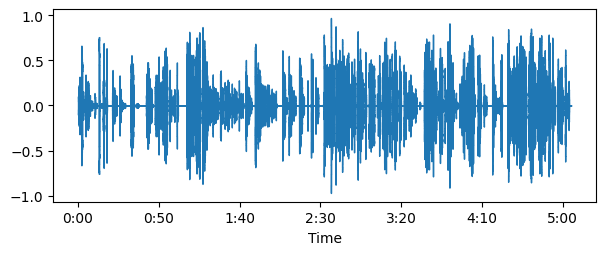

c:\Python\3.10.8\lib\site-packages\torch\nn\modules\module.py:1194: UserWarning: operator () profile_node %668 : int[] = prim::profile_ivalue(%666)
 does not have profile information (Triggered internally at ..\torch\csrc\jit\codegen\cuda\graph_fuser.cpp:109.)
  return forward_call(*input, **kwargs)


,id,start,end,so_start,so_end,word_segments,text
0,0,4640,23008,0,18368,text start end parent_id 0 Oh ...,"Oh my god, he's loud again."
1,1,30240,56288,18368,44416,text start end parent_id 6 Hello...,Hello Craig. Turn him down.
2,2,81440,90592,44416,53568,text start end parent_id 11 He 5186...,He
3,3,95776,107488,53568,65280,text start end parent_id 12 was ...,was down.
4,4,121888,150496,65280,93888,text start end parent_id 14 N...,Now he's loud again. Well that's because you b...


In [12]:
waveform = whisperx.load_audio(example_5_min)
vizualize_waveform(waveform)
test_output = process_audio(waveform)
test_output.head()

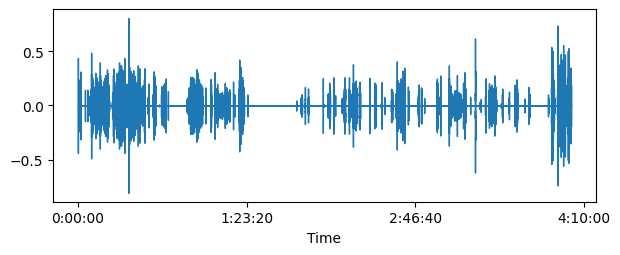

In [17]:
file = "..\\data\\db_02-03-2023\\V8DcTChKFF_data\\1-CS12_4510.ogg"
cs12 = whisperx.load_audio(file)
vizualize_waveform(cs12)


In [18]:
audio = cs12
df, speech_only_waveform, (vad_segments, speech_only_segments) = get_vad_data(audio)

In [60]:
segment_ranges = [range(x,y) for x,y in df[['so_start','so_end']].values]
word_ranges = [range(x,y) for x,y in adf[['start','end']].values]

ids = []
for word_segment in word_ranges:
    for i, segment in enumerate(segment_ranges):
        if get_segment_overlap_percent(segment, word_segment) > .5:
            ids.append(i)
            break
    else:
        ids.append(None)
adf['parent_id'] = ids

f = lambda x: adf[adf['parent_id'] == x['id']]
df['word_segments'] = df.apply(f, axis=1)

f = lambda x: ' '.join(x['word_segments']['text'].to_list())
df['text'] = df.apply(f, axis=1)

df.head()

,id,start,end,so_start,so_end,word_segments,text
0,0,2080,17376,0,15296,text start end parent_id 0 ...,Now recording.
1,1,363552,382432,15296,34176,text start end parent_id 2 You 16...,"You know Josh, he could have just"
2,2,384544,416224,34176,65856,text start end parent_id 9 rig...,"right clicked him and did a server mute,"
3,3,425504,444896,65856,85248,text start end parent_id 17 but ...,but this works too.
4,4,538144,566752,85248,113856,text start end parent_id 21 An...,"Anyway, welcome."


In [90]:
df['end'] - df['start']

0      15296
1      18880
2      31680
3      19392
4      28608
       ...  
911    18368
912    36800
913    10176
914    59840
915    15296
Length: 916, dtype: int64

In [91]:
df['length'] = df['end'] - df['start']
df['length2'] = df['so_end'] - df['so_start']

In [96]:
df[df['text'] == ''].head(10)

,id,start,end,so_start,so_end,word_segments,text,length,length2
10,10,3382816,3391456,249216,257856,"Empty DataFrame Columns: [text, start, end, pa...",,8640,8640
18,18,6096928,6110176,574848,588096,"Empty DataFrame Columns: [text, start, end, pa...",,13248,13248
24,24,6854688,6866912,982016,994240,"Empty DataFrame Columns: [text, start, end, pa...",,12224,12224
35,35,8435744,8450016,1676608,1690880,"Empty DataFrame Columns: [text, start, end, pa...",,14272,14272
38,38,8672288,8677856,1843328,1848896,"Empty DataFrame Columns: [text, start, end, pa...",,5568,5568
39,39,8699936,8729568,1848896,1878528,"Empty DataFrame Columns: [text, start, end, pa...",,29632,29632
40,40,8731168,8738784,1878528,1886144,"Empty DataFrame Columns: [text, start, end, pa...",,7616,7616
42,42,8807456,8824800,1931648,1948992,"Empty DataFrame Columns: [text, start, end, pa...",,17344,17344
44,44,8949792,8963552,2002688,2016448,"Empty DataFrame Columns: [text, start, end, pa...",,13760,13760
45,45,9006112,9020384,2016448,2030720,"Empty DataFrame Columns: [text, start, end, pa...",,14272,14272


In [103]:
page = 0
pagesize = 5

In [121]:
page += 1
a = page*pagesize
b = a+pagesize
print(f'{a}-{b} of {len(vad_segments)}')
for segment in vad_segments[a:b]:
    start = segment['start']
    end = segment['end']
    print(start,end, end-start)
    listen_waveform(audio[start:end])

90-95 of 916
13110816 13123040 12224


13150752 13177312 26560


13179936 13189088 9152


13192224 13207520 15296


13212704 13220320 7616


In [97]:
# for start, end in df[df['text'] == ''][['so_start','so_end']].values :
#     print(start, end, end-start)
#     listen_waveform(speech_only_waveform[start:end])

In [68]:
df[df['end'] - df['start'] < 10000]

,id,start,end,so_start,so_end,word_segments,text
8,8,1236512,1245152,187392,196032,text start end parent_id 41 belo...,below.
10,10,3382816,3391456,249216,257856,"Empty DataFrame Columns: [text, start, end, pa...",
38,38,8672288,8677856,1843328,1848896,"Empty DataFrame Columns: [text, start, end, pa...",
40,40,8731168,8738784,1878528,1886144,"Empty DataFrame Columns: [text, start, end, pa...",
52,52,9523744,9530848,2228992,2236096,"Empty DataFrame Columns: [text, start, end, pa...",
...,...,...,...,...,...,...,...
894,894,230824480,230830048,36753536,36759104,"Empty DataFrame Columns: [text, start, end, pa...",
895,895,230848544,230858208,36759104,36768768,text start end parent_id 4702...,be like
897,897,231521312,231528928,36801472,36809088,text start end parent_id 471...,"Also, I"
904,904,232451104,232456672,37172736,37178304,"Empty DataFrame Columns: [text, start, end, pa...",


In [51]:
project

{'project_name': 'V8DcTChKFF_data',
 'root_path': '../data/db_02-03-2023',
 'data_path': '../data/db_02-03-2023\\V8DcTChKFF_data',
 'files': [{'filename': '1-CS12_4510.ogg', 'offset': 0.0},
  {'filename': '2-Crux_4429.ogg', 'offset': 0.0},
  {'filename': '3-JadePixie_7138.ogg', 'offset': 0.0},
  {'filename': '4-IlMaximuslI_9218.ogg', 'offset': 0.0}]}

../data/db_02-03-2023\V8DcTChKFF_data\1-CS12_4510.ogg


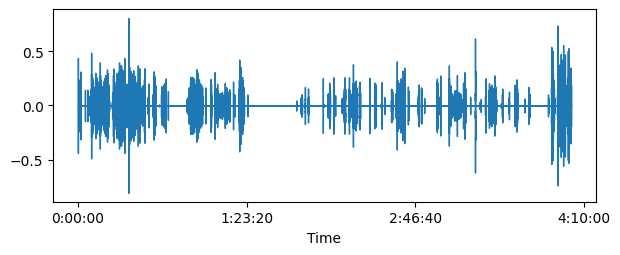

../data/db_02-03-2023\V8DcTChKFF_data\2-Crux_4429.ogg


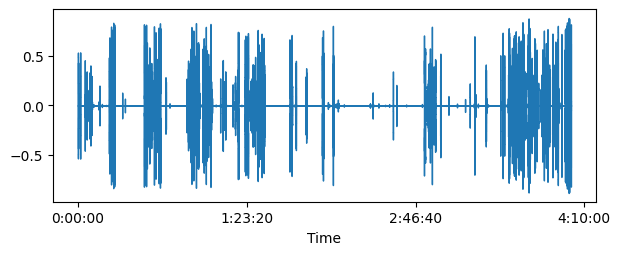

../data/db_02-03-2023\V8DcTChKFF_data\3-JadePixie_7138.ogg


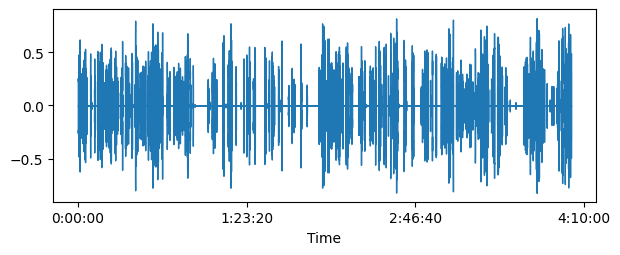

../data/db_02-03-2023\V8DcTChKFF_data\4-IlMaximuslI_9218.ogg


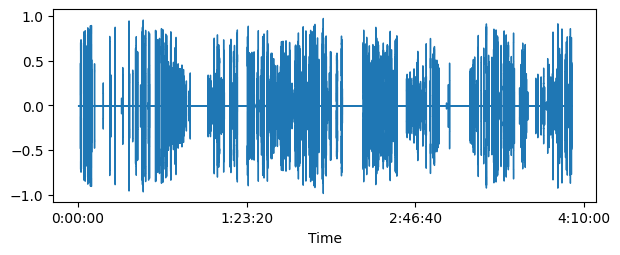

[('1-CS12_4510.ogg', array([0.00344849, 0.00344849, 0.003479  , ..., 0.        , 0.        ,
       0.        ], dtype=float32)), ('2-Crux_4429.ogg', array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)), ('3-JadePixie_7138.ogg', array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)), ('4-IlMaximuslI_9218.ogg', array([0., 0., 0., ..., 0., 0., 0.], dtype=float32))]


In [52]:
waveforms = []
for file in project.get('files'):
    filename = file.get('filename')
    filepath = os.path.join(project.get('data_path'), filename)
    print(filepath)
    wav = whisperx.load_audio(filepath)
    vizualize_waveform(wav)
    waveforms.append((filename, wav))

print(waveforms)

In [58]:
transcript_dfs = []
for filename, waveform in waveforms:
    df, adf = process_audio(waveform)
    out = {
        'speaker': get_discord_name(filename),
        'filename': filename,
        'full': df,
        'words': adf
    }
    transcript_dfs.append(out)

ValueError: Length of values (2082975) does not match length of index (4794)

In [59]:
transcript_dfs

[]